# Visualize physiological paramters

This script visualizes how changing the physiological paramters changes the reflected spectrum

In [1]:
# 1.1 create spectra - setup simulation environment
# not necessary to read this

# some necessary imports
import logging
import numpy as np
import os
# everything related to the simulation wrapper
from mc import sim
# the factories create batches (tissue samples) and suited tissue models
from mc import factories
# the tissueparser reads a tissue init file
# examples can be found in mc/data/tissues
from mc import tissueparser

# the usual settings for plotting in ipython notebooks
import matplotlib.pylab as plt
%matplotlib inline

# Where does your monte carlo simulation executable resides in?
MCML_EXECUTABLE = "/home/wirkert/workspace/monteCarlo/gpumcml/fast-gpumcml/gpumcml.sm_20"
# The wavelengths for which we want to run our simulation
WAVELENGTHS = np.arange(450, 978, 2) * 10 ** -9
# number of batch to simulate
BATCH_NR = 0
# batch_prefix
BATCH_PREFIX = "tutorial_batch"
# The MCML needs a simulation input file, where shall it be created?
MCI_FILENAME = "./" + BATCH_PREFIX + "_" + str(BATCH_NR) + ".mci"

# we want to create standard colonic tissue as specified in the IPCAI 2016 publication
# "Robust Near Real-Time Estimation of Physiological Parameters from Megapixel
# Multispectral Images with Inverse Monte Carlo and Random Forest Regression"
factory = factories.GenericMcFactory()

# create a simulation wrapper
sim_wrapper = sim.SimWrapper()
# our simulation needs to know where the input file for the simulation
# shall resign (will be automatically created)
sim_wrapper.set_mci_filename(MCI_FILENAME)
# also it needs to know where the simulation executable shall lie in
sim_wrapper.set_mcml_executable(MCML_EXECUTABLE)

# create the tissue model
# it is responsible for writing the simulation input file
tissue_model = factory.create_tissue_model()
# tell it where the input file shall lie in
tissue_model.set_mci_filename(sim_wrapper.mci_filename)
# tell it how much photons shall be simulated. Will be set to 10**6 by standard,
# this is just an example
tissue_model.set_nr_photons(10**6)

In [4]:
# convenience function for creating simulations and plotting

def plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, normalize=False):
    
    # enter total number of simulations for mci file generation
    total_nr_mc_simulations = NR_ELEMENTS_IN_BATCH * len(WAVELENGTHS)
    tissue_model._mci_wrapper.set_nr_runs(total_nr_mc_simulations)            
    # create the header for the mci file
    tissue_model.create_mci_file()
    
    # the file where the tissue is specified.
    # switch out this file with your tissue specification to 
    # create samples from a different tissue spec.
    tissue_instance = tissueparser.read_tissue_config(TISSUE_CONFIG_FILE)

    # setup batch with tissue instances which should be simulated
    batch = factory.create_batch_to_simulate()
    # tell the batch whcih tissue it should create samples from
    batch.set_tissue_instance(tissue_instance)
    # we want to simulate ten tissue instances in this example
    df = batch.create_tissue_samples(NR_ELEMENTS_IN_BATCH)
    
    # add reflectance column to dataframe
    for w in WAVELENGTHS:
        df["reflectance", w] = np.NAN # the reflectances have not been calculated yet, thus set no nan

    # small helper function to create mco filenames:
    def _create_mco_filename_for(prefix, batch, simulation):
        return str(prefix) + "_Bat_" + str(batch) + "_Sim_" + str(simulation) + "_"

    for i in range(df.shape[0]):
        # set the desired element in the dataframe to be simulated
        base_mco_filename = _create_mco_filename_for(BATCH_PREFIX,
                                                     BATCH_NR,
                                                     i)
        tissue_model.set_base_mco_filename(base_mco_filename)
        tissue_model.set_tissue_instance(df.loc[i, :])
        tissue_model.update_mci_file(WAVELENGTHS)

    # Run simulations for the created mci file
    sim_wrapper.run_simulation()

    # get information from created mco files
    for i in range(df.shape[0]):
        for wavelength in WAVELENGTHS:
            # for simulation get which mco file was created
            simulation_path = os.path.split(sim_wrapper.mcml_executable)[0]
            base_mco_filename = _create_mco_filename_for(BATCH_PREFIX,
                                                         BATCH_NR,
                                                         i)
            mco_filename = base_mco_filename + str(wavelength) + '.mco'
            # get diffuse reflectance from simulation
            df["reflectance", wavelength][i] = \
                sim.get_diffuse_reflectance(os.path.join(simulation_path, mco_filename))
            # delete created mco file
            os.remove(os.path.join(simulation_path, mco_filename))

    ylabel = "reflectance"
    if normalize:
        df["reflectance"] = df["reflectance"].values / np.expand_dims(np.sum(df["reflectance"].values, axis=1), axis=1)
        ylabel = "normalized " + ylabel
            
    # let's have a look at our reflectances
    df["reflectance"].T.plot(kind="line", cmap=plt.get_cmap("seismic"), figsize=(10,10))
    plt.ylabel(ylabel)
    plt.xlabel("wavelengths [m]")
    plt.title(os.path.split(TISSUE_CONFIG_FILE)[1] + " -- " + " blue is small, red is high")
    plt.legend().set_visible(False)
    plt.grid()
    

# Plotting

now onto the interesting part, print the spectra, varing only one paramter at a time


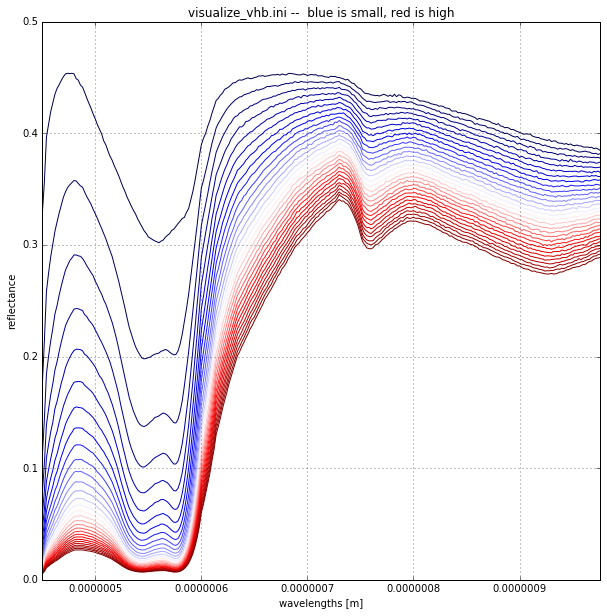

In [5]:
# This file varies only vhb, keeping the other parameters constant. It does this in 10 steps
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_vhb.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

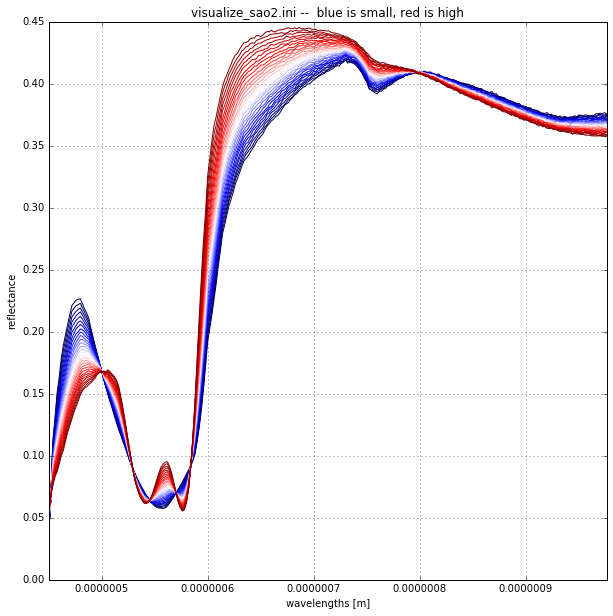

In [6]:
# This file varies only sao2, keeping the other parameters constant. It does this in 10 steps
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_sao2.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

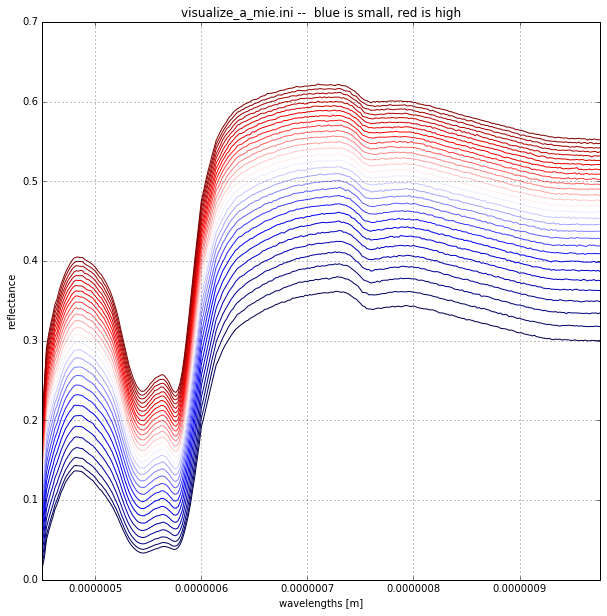

In [7]:
# This file varies only a_mie, keeping the other parameters constant. It does this in 10 steps
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_a_mie.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

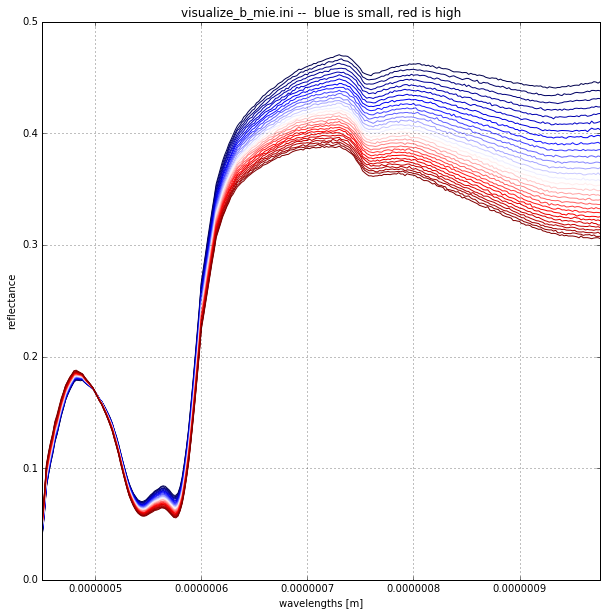

In [8]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_b_mie.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

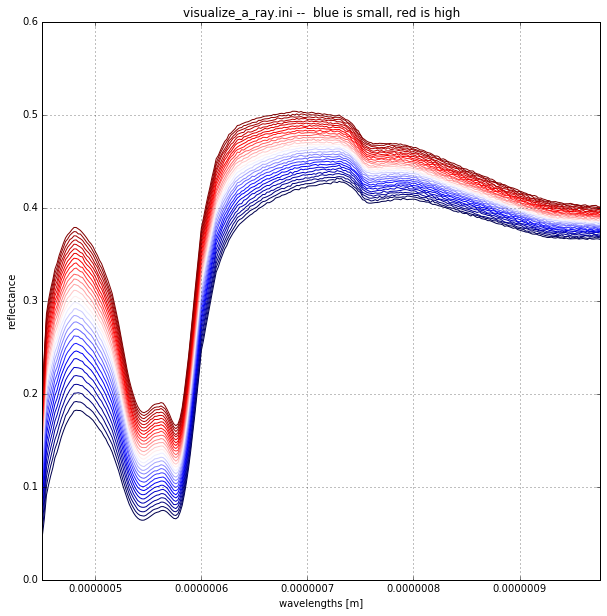

In [9]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_a_ray.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

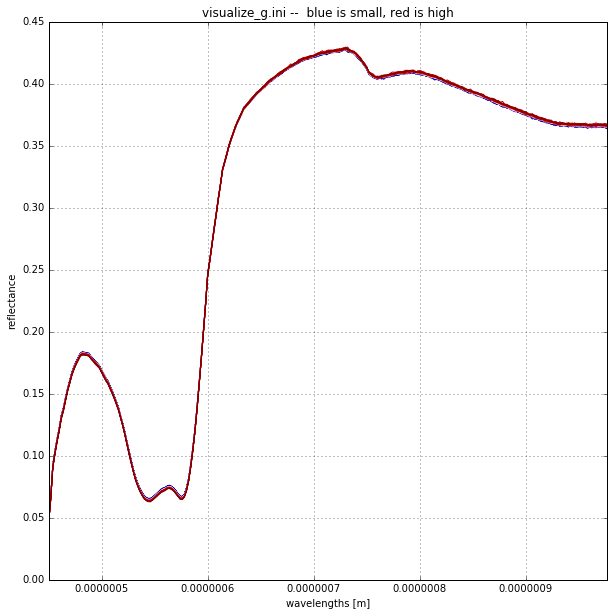

In [10]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_g.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

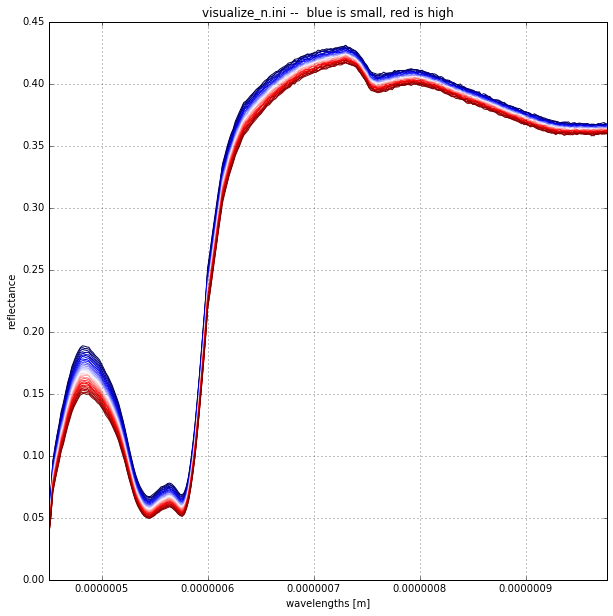

In [11]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_n.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

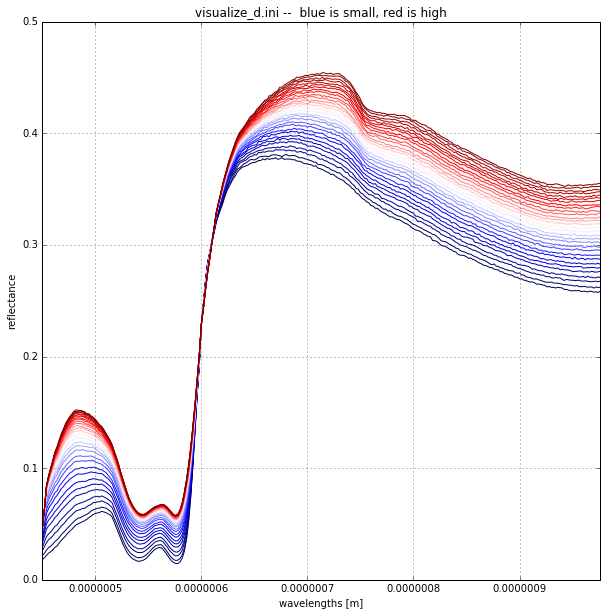

In [12]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_d.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH)

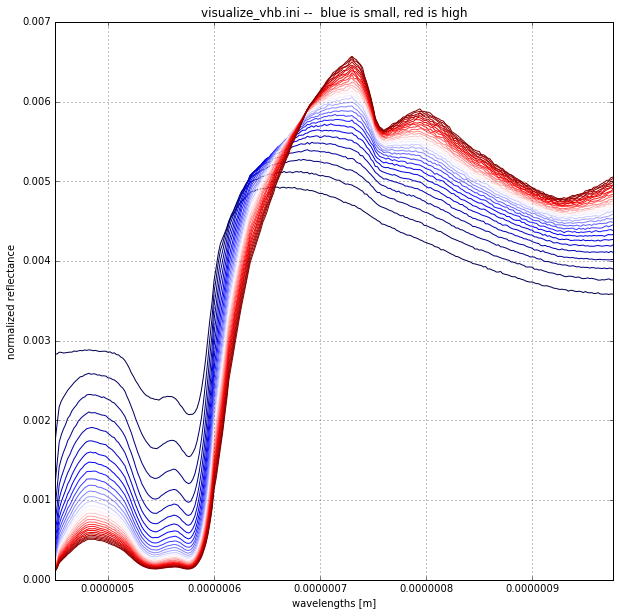

In [13]:
# This file varies only vhb, keeping the other parameters constant. It does this in 10 steps
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_vhb.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

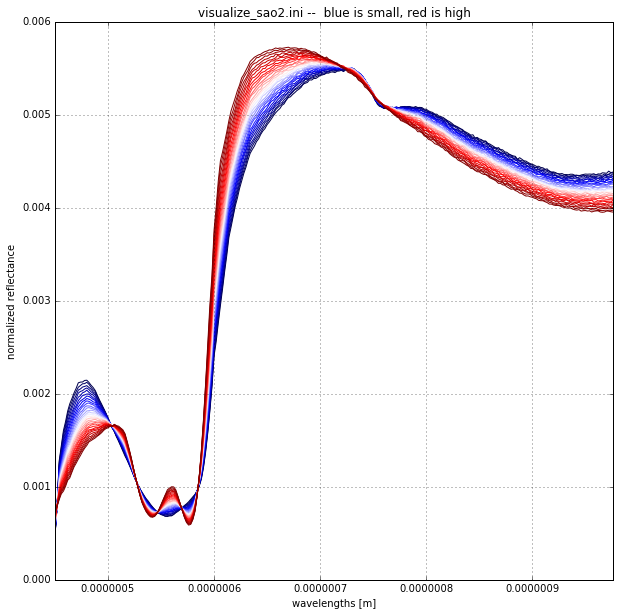

In [14]:
# This file varies only sao2, keeping the other parameters constant. It does this in 10 steps
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_sao2.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

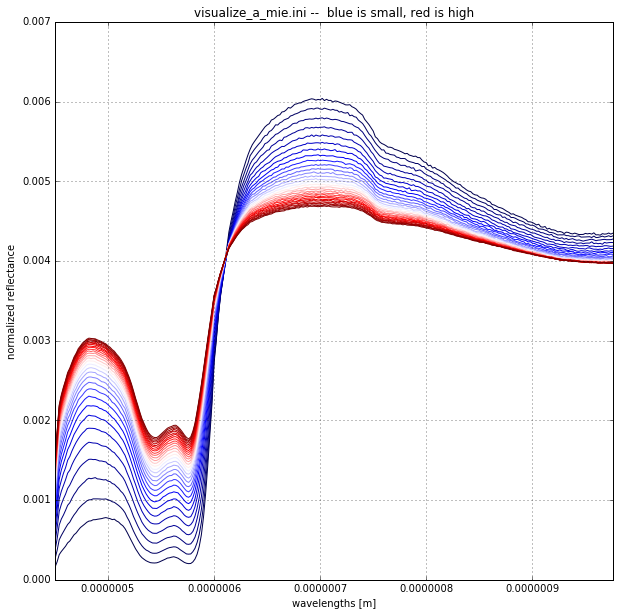

In [15]:
# This file varies only a_mie, keeping the other parameters constant. It does this in 10 steps
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_a_mie.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

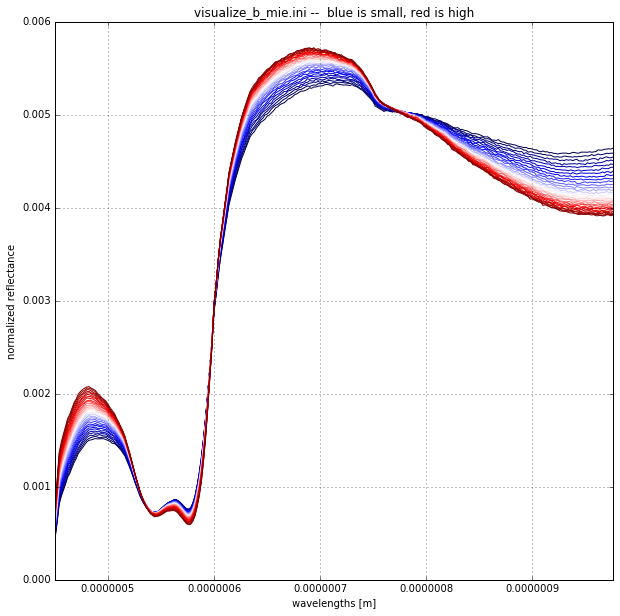

In [16]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_b_mie.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

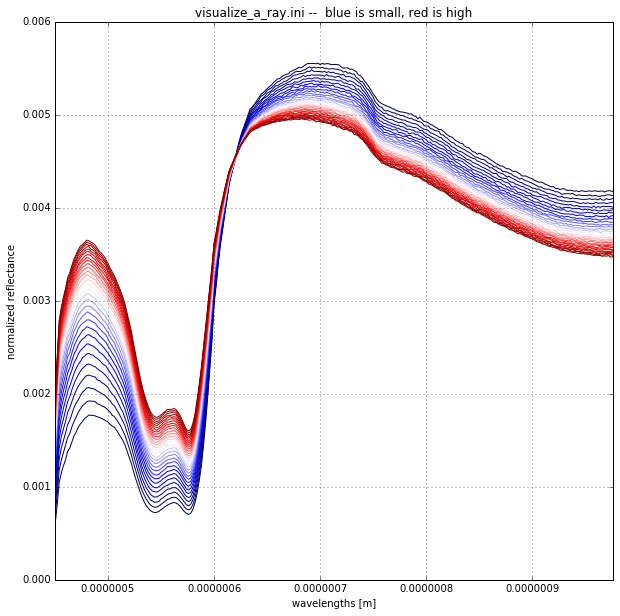

In [17]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_a_ray.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

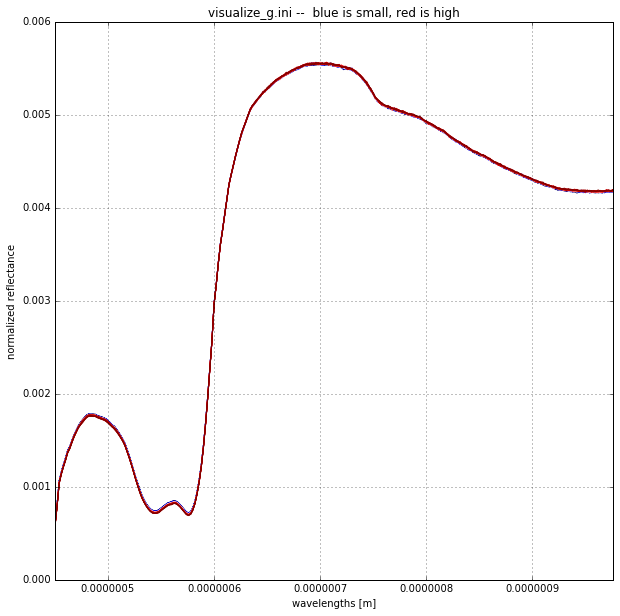

In [18]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_g.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

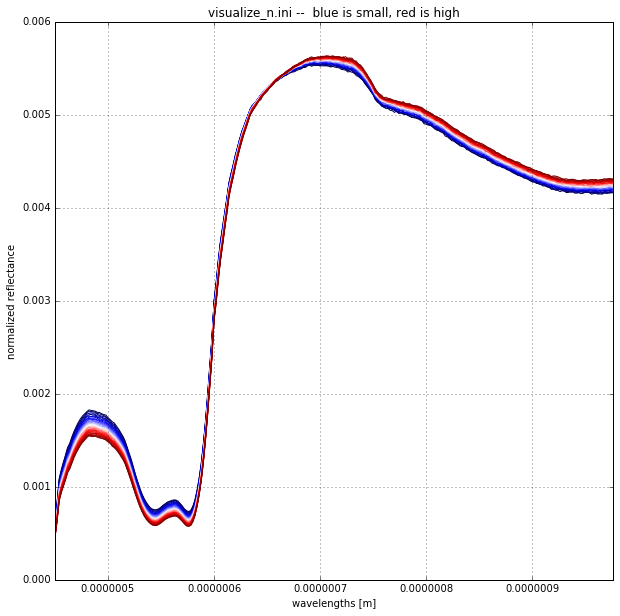

In [19]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_n.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)

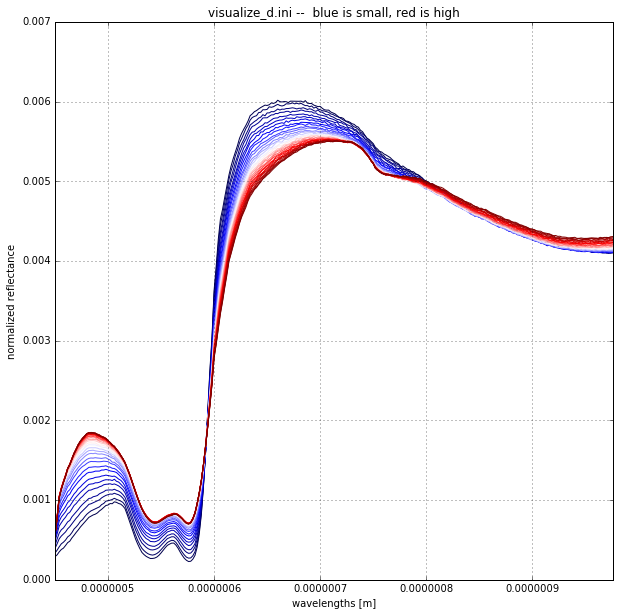

In [20]:
TISSUE_CONFIG_FILE = "../mc/data/tissues/visualize_d.ini"
NR_ELEMENTS_IN_BATCH = 30
plot_tissue(TISSUE_CONFIG_FILE, NR_ELEMENTS_IN_BATCH, True)